In [2]:
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib import pyplot
from math import sqrt

import numpy as np
from numpy import log

import pandas as pd
from datetime import datetime, timedelta
from pandas.plotting import lag_plot
from pandas import DataFrame
from pandas import concat



import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.stattools import AutoReg
from statsmodels.tsa.ar_model import AR
!pip install -U AutoReg
from AutoReg import AutoReg

import sklearn as sk

import seaborn as sns
plt.style.use('seaborn-whitegrid')


warnings.filterwarnings("ignore")

Reads Loreal sales turnover time-series data [2015-2021] (Data Source: https://www.loreal-finance.com/eng/share-price)

In [3]:
loreal_stock_df_2015_2021=pd.read_csv("/content/price-lookup-L'OREAL-MONTH-2015-08-03-2021-08-03.csv",delimiter=";")

Formatting

In [4]:
#Remove Extra Columns
df_train = loreal_stock_df_2015_2021.drop(['Opening', 'Highest price','Lowest price', 'Closing price','Volume'], axis=1)
#DateTime Format
df_train['Date']=pd.to_datetime(df_train['Date'])
df_train.head()

,Date,Turnover
0,2015-08-31,2.733047e+09
1,2015-09-30,2.740650e+09
2,2015-10-30,3.061263e+09
3,2015-11-30,2.132360e+09
4,2015-12-31,2.260586e+09


Compute the overall sales trend using seasonal decomposition using moving averages and a periodicity of 6 months [2015-2021]

In [6]:
trend_dict= {}
#for ts in loreal_turnover_df_covid.columns:
trend_sales = sm.tsa.seasonal_decompose(df_train["Turnover"].dropna(),model='additive', filt=None, freq=6, two_sided=True, extrapolate_trend=0)
# Store back the results
trend_dict["Turnover_trend"] = trend_sales.trend
df_trend=pd.DataFrame(trend_dict)


Plot[1]: Barplot of the sales turnover time-series 

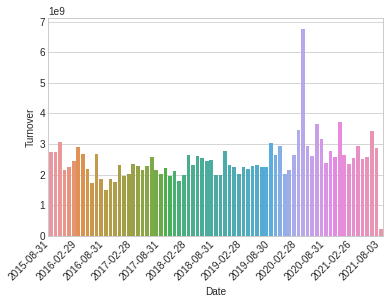

In [7]:
fig, ax = plt.subplots()
fig=sns.barplot(x='Date',y='Turnover',data=df_train,ax=ax)
#pd.DataFrame(trend_dict).plot()
#Plot frequency=6 months
freq = int(6)

#Formatting the xtics
xlabels=ax.set_xticklabels(df_train.iloc[::freq].Date.dt.date)
xtix = ax.get_xticks()
ax.set_xticks(xtix[::freq])
ax.set_xticklabels(xlabels,rotation=45, ha='right')
plt.show()

#Note: Sales peak reached around March, 2020 -- the time when Covid19 pandemic started causing a mass panic

Plot[2]: Sales Trend Plot [2015-2021]

Text(0, 0.5, 'Seasonal trend for sales turnover')

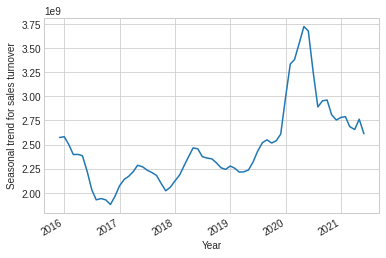

In [8]:
dfs = [df_train,df_trend]
trend= pd.concat(dfs,axis=1)
trend['Date']=pd.to_datetime(trend['Date'])
trend=trend.set_index(['Date'])
trend['Turnover_trend'].plot()
plt.xlabel('Year')
plt.ylabel('Seasonal trend for sales turnover')

Perform a Dicky-Fuller test to check the stationarity of the turnover data (p <0.05 means data is stationary and differencing is not necessary)

In [9]:
result = adfuller(df_train.Turnover.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.405379
p-value: 0.000003


Plotting the auto-correlation and partial autocorrelation for the sales turnover time-series 

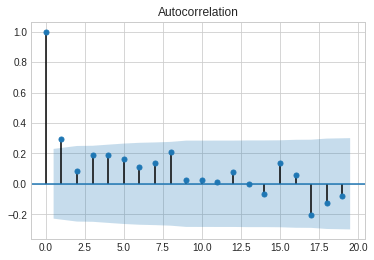

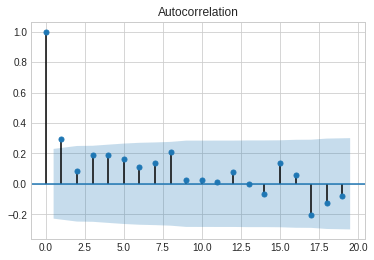

In [10]:
plot_acf(df_train.Turnover)
#plot_pacf(df_train.Turnover)

#We observe that both autocorrelation and partial auto-correlations cross the significant line upto the 1st lag. 
#Choice of model: Since lags are not correlated, simple auto-regression AR model should work just fine!

The simplest model that we could use to make predictions would be to persist the last observation and we can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

In [11]:
# create lagged dataset
values = DataFrame(df_train.Turnover)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
dataframe.head()

,t-1,t+1
0,NaN,2.733047e+09
1,2.733047e+09,2.740650e+09
2,2.740650e+09,3.061263e+09
3,3.061263e+09,2.132360e+09
4,2.132360e+09,2.260586e+09


In [12]:
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-6], X[len(X)-6:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [13]:
# persistence model
def model_persistence(x):
	return x

In [14]:
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)

Predictions from persistence model

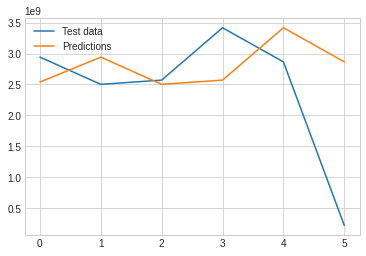

In [15]:
# plot predictions vs expected
testplot=plt.plot(test_y, label='Test data')
predplot=plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

The persistence model is not predicting well as was expected. We shall now split our dataset to train using autoregression AR model and then test the validity on the test dataset. 
Assumptions: Since the Covid19 dataset is of a size ~ 24 months and the trend of the dataset changes from Feb 2020, we choose the length of training data as large as possible. We will later use this to forecast the future behaviour as well.
 

In [16]:
# split dataset
X = df_train.Turnover
#print(X)
train, test = X[1:len(X)-6], X[len(X)-6:]
print(test)

67    2.942362e+09
68    2.502026e+09
69    2.570509e+09
70    3.416698e+09
71    2.864942e+09
72    2.223595e+08
Name: Turnover, dtype: float64


In [17]:
#train autoregression
model = AR(train)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
#AutoReg
#len(test)

Coefficients: const           9.709743e+08
L1.Turnover     3.430748e-01
L2.Turnover    -5.284861e-02
L3.Turnover     1.536572e-01
L4.Turnover     1.729301e-02
L5.Turnover     1.320080e-01
L6.Turnover    -2.999721e-02
L7.Turnover     1.517343e-02
L8.Turnover     1.845623e-01
L9.Turnover    -6.681517e-02
L10.Turnover   -8.289002e-03
L11.Turnover   -7.497990e-02
dtype: float64


We use the AR coefficients to validate 12 months of test data and for making predictions for another 12 months

In [18]:
# make predictions
predictions = model_fit.predict(start=len(train)-24, end=len(train)+12, dynamic=False)
#print(predictions)
df_train.tail()

,Date,Turnover
68,2021-04-30,2.502026e+09
69,2021-05-31,2.570509e+09
70,2021-06-30,3.416698e+09
71,2021-07-30,2.864942e+09
72,2021-08-03,2.223595e+08


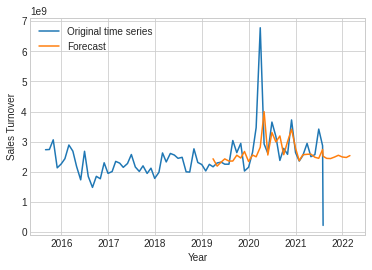

In [38]:
#print(predictions)
pred_dict= {}
pred_dict["Turnover_predictions"] = predictions
df_pred=pd.DataFrame(pred_dict)
df_pred.head()
#df_train=df_train.set_index(['Date'])
df_pred.index
#for i in range(df_pred.index):
#  df_pred.index = df_train.index 
#df_pred['Turnover predictions']=pd.DataFrame(predictions)
#df_train.head()
dfs = [df_train,df_pred]
pred= pd.concat(dfs,axis=1)
#print(pred)
#pred['Date']=pd.to_datetime(pred['Date'])
#trend=trend.set_index(['Date'])
#trend['Turnover_trend'].plot()
#plt.xlabel('Year')
#plt.ylabel('Seasonal trend for sales turnover')
#pred=pred.set_index(['Date'])

#plt.plot()
#plt.plot(predictions, color='red', label='Forecast')
#plt.legend()
#plt.show()


date_list = ['2021-08-31','2021-09-30','2021-10-31','30-11-2021','31-12-2021','31-01-2022','28-02-2022']
for  date,i in zip(date_list,range(73,80)):
  pred.at[i,'Date'] = pd.to_datetime(date)
pred=pred.set_index(['Date'])
plt.plot(pred.Turnover,label='Original time series')
plt.plot(pred.Turnover_predictions, label='Forecast')
plt.xlabel('Year')
plt.ylabel('Sales Turnover')
plt.legend()


Comments:


1.   The sharp jump around Feb, 2020 can not be exactly captured by AR. Understandably so, because the previous training data had no such trends.
2.   Post Feb 2020, the trend till 2021 is captured quite well. There is a dip in the turnover in July-August 2021. Since COVID19 is setting new trends in the sales data, the model needs to be trained with a longer time series, to be able to rightly capture the actual behaviour. The model predicts the sales to stabilise during Sep, 2021 - Feb, 2022. 


